In [51]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import  lime
import matplotlib.pyplot as plt

# Load the CSV file
data = pd.read_csv('/home/zubair/Downloads/optimization_log 1.csv')

# Process "Solution" column by stripping brackets and converting to floats
X = data["Solution"].apply(lambda x: np.array([float(i.strip("[]")) for i in x.split(',')]))
X = np.stack(X.values)  # Stack arrays into a 2D array

# Clean and convert "Fitness" column to a numpy array of floats
y_reg = data["Fitness"].apply(lambda x: float(x.strip("[]").strip())).values


# Convert "Satisfied Constraint" to binary values (1 for 'Yes', 0 otherwise)
y_class = data["Satisfied Constraints"].apply(lambda x: 1 if x == 9 else 0).values

# Split data into training and testing sets
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
_, _, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)

In [52]:
# Filter rows where Column B equals 1
filtered_df = data[data['Satisfied Constraints'] == 9]

# Find the row with the minimum value in Column A
min_row = filtered_df.loc[filtered_df['Fitness'].idxmin()]


# Get the index of the row with the minimum value in Column A
min_row_index = min_row.name
print("min row index: ", min_row_index)
print("min row: ", min_row)
# Get the corresponding 'Solution' value for the min row index
min_row_solution_value = data.loc[min_row_index, 'Solution']

# Transform the solution value as you did for X
best_sol__X = np.array([float(i.strip("[]")) for i in min_row_solution_value.split(',')])


min row index:  2437
min row:  Generation                                                              25
Solution                 [0.30014286146690117, 0.7577818705388193, 0.28...
Fitness                                             [-0.14755866554345332]
Constraints              [-7.462482664162775, -8.118992133661868, -7.30...
Satisfied Constraints                                                    9
Name: 2437, dtype: object


In [53]:
num_features = X_train.shape[1]

# Calculate correlations
reg_correlations = np.array([np.corrcoef(X_train[:, i], y_train_reg)[0, 1] for i in range(num_features)])

class_correlations = np.array([np.corrcoef(X_train[:, i], y_train_class)[0, 1] for i in range(num_features)])


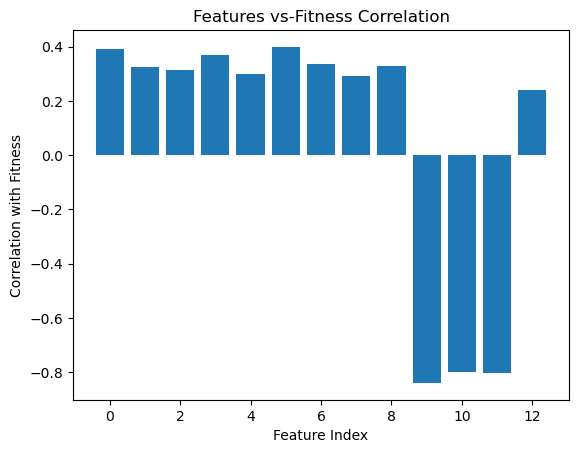

In [54]:
# Plot the correlation values
plt.bar(range(num_features), reg_correlations)
plt.xlabel('Feature Index')
plt.ylabel('Correlation with Fitness')
plt.title('Features vs-Fitness Correlation')
plt.show()

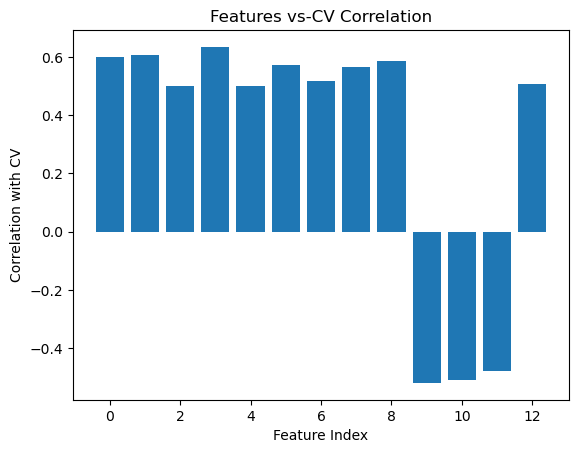

In [55]:
plt.bar(range(num_features), class_correlations)
plt.xlabel('Feature Index')
plt.ylabel('Correlation with CV')
plt.title('Features vs-CV Correlation')
plt.show()

In [56]:
feature_names=[f'Feature_{i}' for i in range(X.shape[1])]
# Initialize models
regressor = RandomForestRegressor(n_estimators=100, random_state=42) # LinearRegression() 
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train models
regressor.fit(X_train, y_train_reg)
classifier.fit(X_train, y_train_class)

# Test models
y_pred_reg = regressor.predict(X_test)
y_pred_class = classifier.predict(X_test)

# Evaluate models
mse = mean_squared_error(y_test_reg, y_pred_reg)
accuracy = accuracy_score(y_test_class, y_pred_class)

print(f"Regression MSE: {mse}")
print(f"Classification Accuracy: {accuracy}")


Regression MSE: 3.4984952462682806
Classification Accuracy: 0.9975


In [57]:
from lime import lime_tabular
limeRegressionExplainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    mode="regression",  # We'll use this mode for both models separately
    feature_names=feature_names,
    random_state=42
)

limeClassifierExplainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    mode="classification",  # We'll use this mode for both models separately
    feature_names=feature_names,
    class_names=np.unique(y_pred_class),
    random_state=42
)

# Function to get feature importance for both models
def get_feature_importance_lime(explainer, model, X_sample):
    if explainer.mode == 'regression':
        exp = explainer.explain_instance(X_sample, model.predict, num_features=X.shape[1])

    elif explainer.mode == 'classification':
        exp = explainer.explain_instance(X_sample, model.predict_proba, num_features=X.shape[1])
    # print(exp.as_list())
    return dict(exp.as_list())

In [58]:
# Test with a sample and store importance scores
#sample = X_test[0]
best_sol_score_reg = get_feature_importance_lime(limeRegressionExplainer, regressor, best_sol__X)
best_sol_score_class = get_feature_importance_lime(limeClassifierExplainer, classifier, best_sol__X)

In [59]:
import re
def extractFeatureNameFromLimeScoreRange(featureNameWithScoreRange):
    # Input string
    input_string = featureNameWithScoreRange
    feature_name = "dummy"
    # Find the start index of 'Feature_'
    start_index = input_string.find("Feature_")

# If 'Feature_' is found, extract the feature name
    if start_index != -1:
        feature_name = input_string[start_index:start_index + input_string[start_index:].find(' ')]
    return feature_name
# extractFeatureNameFromLimeScoreRange('2.26 < Feature_11 <= 2.91')

In [60]:
def fixFeatureNameinLimeExpDictionary(limeExpDict):
    limeDictWithFixedFeatureNames = {extractFeatureNameFromLimeScoreRange(key): value for key, value in limeExpDict.items()}
    return limeDictWithFixedFeatureNames

In [61]:
def sortDictByKeys(limeExpDict):
    sorted_dict = {k: limeExpDict[k] for k in sorted(limeExpDict, key=lambda x: int(x.split('_')[1]))}
    return sorted_dict

In [62]:
def sortAsLimeExpAsNumpyAr(limeExpDict):    
    # Create a NumPy array where each row is a feature score
    fixedLimeDict = fixFeatureNameinLimeExpDictionary(limeExpDict)
    sortedLimeDictByKeys = sortDictByKeys(fixedLimeDict)
    importance_array = np.array(list(sortedLimeDictByKeys.values())).reshape(1, -1)

    # Optionally, map feature names to columns
    feature_names_array = np.array([list(sortedLimeDictByKeys.keys())]).reshape(1, -1)
    
    # Optionally, you can return both feature names and scores as a 2D array
    result_array = np.vstack((feature_names_array, importance_array))
    return result_array

In [ ]:
reg_lime_score = None
class_lime_score = None
for x in X_test :
    # for regression
    reg_scores = get_feature_importance_lime(limeRegressionExplainer, regressor, x)
    sortedByKey_reg_scores = sortAsLimeExpAsNumpyAr (reg_scores)
    if( reg_lime_score is None):
        reg_lime_score = sortedByKey_reg_scores
    else:
        reg_lime_score = np.vstack((reg_lime_score, sortedByKey_reg_scores[1]))
    
    # for classify
    clas_scores = get_feature_importance_lime(limeClassifierExplainer, classifier, x)
    sortedByKey_clas_scores = sortAsLimeExpAsNumpyAr (clas_scores)
    if( class_lime_score is None):
        class_lime_score = sortedByKey_clas_scores
    else:
        class_lime_score = np.vstack((class_lime_score, sortedByKey_clas_scores[1]))

In [15]:
def plotScores(features, reg_values, class_values, title):
    fig, ax = plt.subplots(1, 2, figsize=(50, 20))

    ax[0].plot(features, reg_values, marker='o', color='blue', linestyle='-', linewidth=1, markersize=5, label='Fitness')
    ax[0].set_xlabel("Features", fontsize=24)
    ax[0].set_ylabel("Importance Score", fontsize=24)
    ax[0].set_title(title, fontsize=24)
    ax[0].tick_params(axis='x', rotation=45, labelsize=20)  # Increase font size for X-axis labels
    ax[0].tick_params(axis='y', labelsize=20)  # Y-axis label font size    
    
    ax[1].plot(features, class_values, marker='o', color='red', linestyle='-', linewidth=1, markersize=5, label='CV')
    ax[1].set_xlabel("Features", fontsize=24)
    ax[1].set_ylabel("Importance Score", fontsize=24)
    ax[1].set_title(title, fontsize=24)
    ax[1].tick_params(axis='x', rotation=45, labelsize=20)  # Increase font size for X-axis labels
    ax[1].tick_params(axis='y', labelsize=20)  # Y-axis label font size  
    plt.tight_layout()
    plt.show()

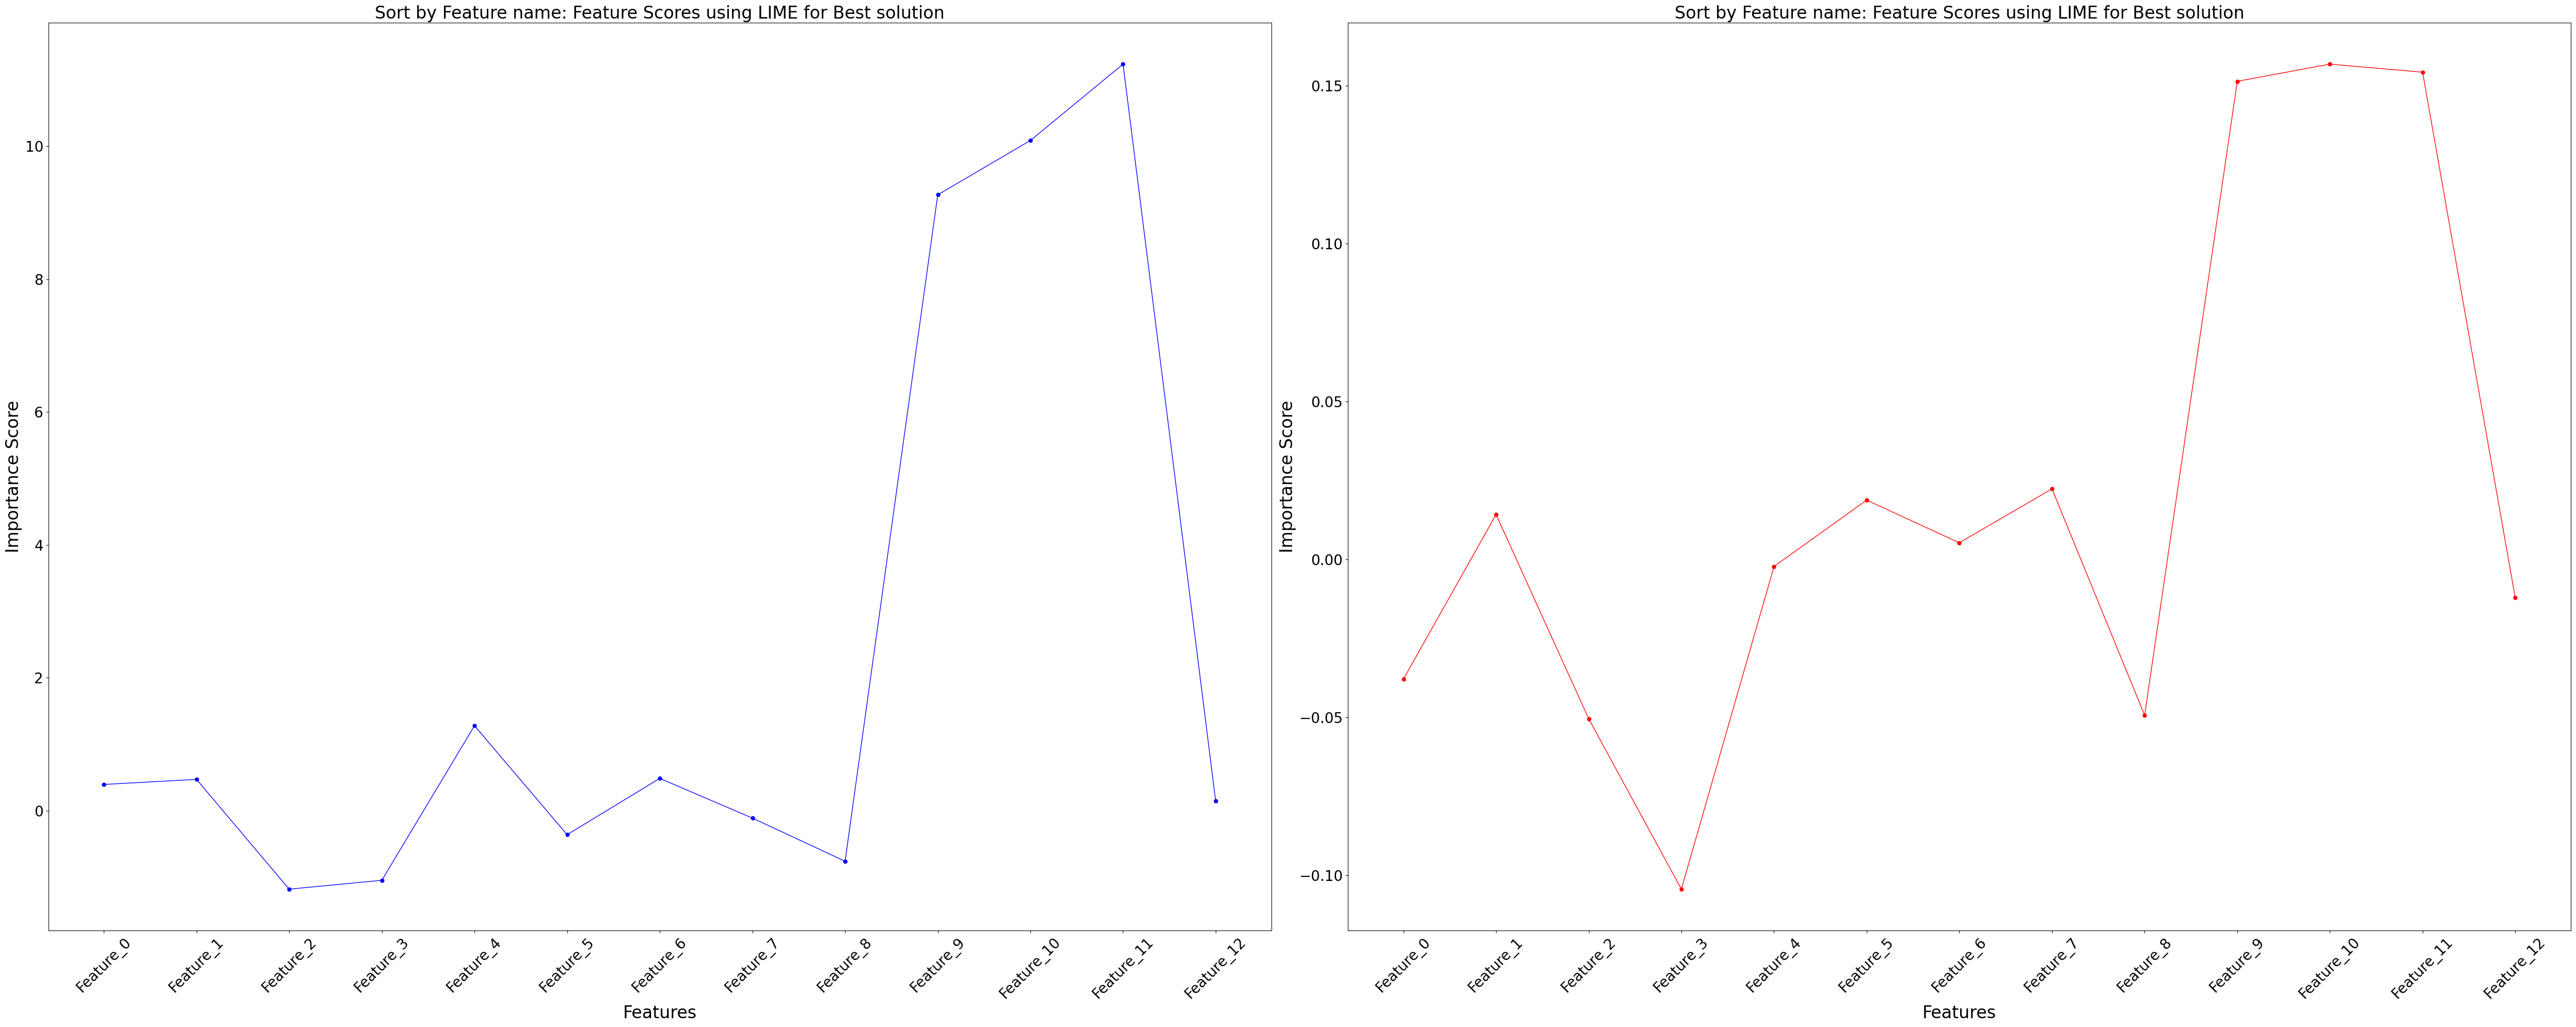

In [16]:
#Sort by Feature name: Feature Importance using LIME for Best solution
score_reg = sortAsLimeExpAsNumpyAr(best_sol_score_reg)
score_class = sortAsLimeExpAsNumpyAr(best_sol_score_class)

features = list(score_reg[0])
reg_score_values = score_reg[1].astype(float)  # Exclude first row and convert to float
class_score_values = score_class[1].astype(float)  # Exclude first row and convert to float

plotScores(features, reg_score_values, class_score_values, "Sort by Feature name: Feature Scores using LIME for Best solution" )


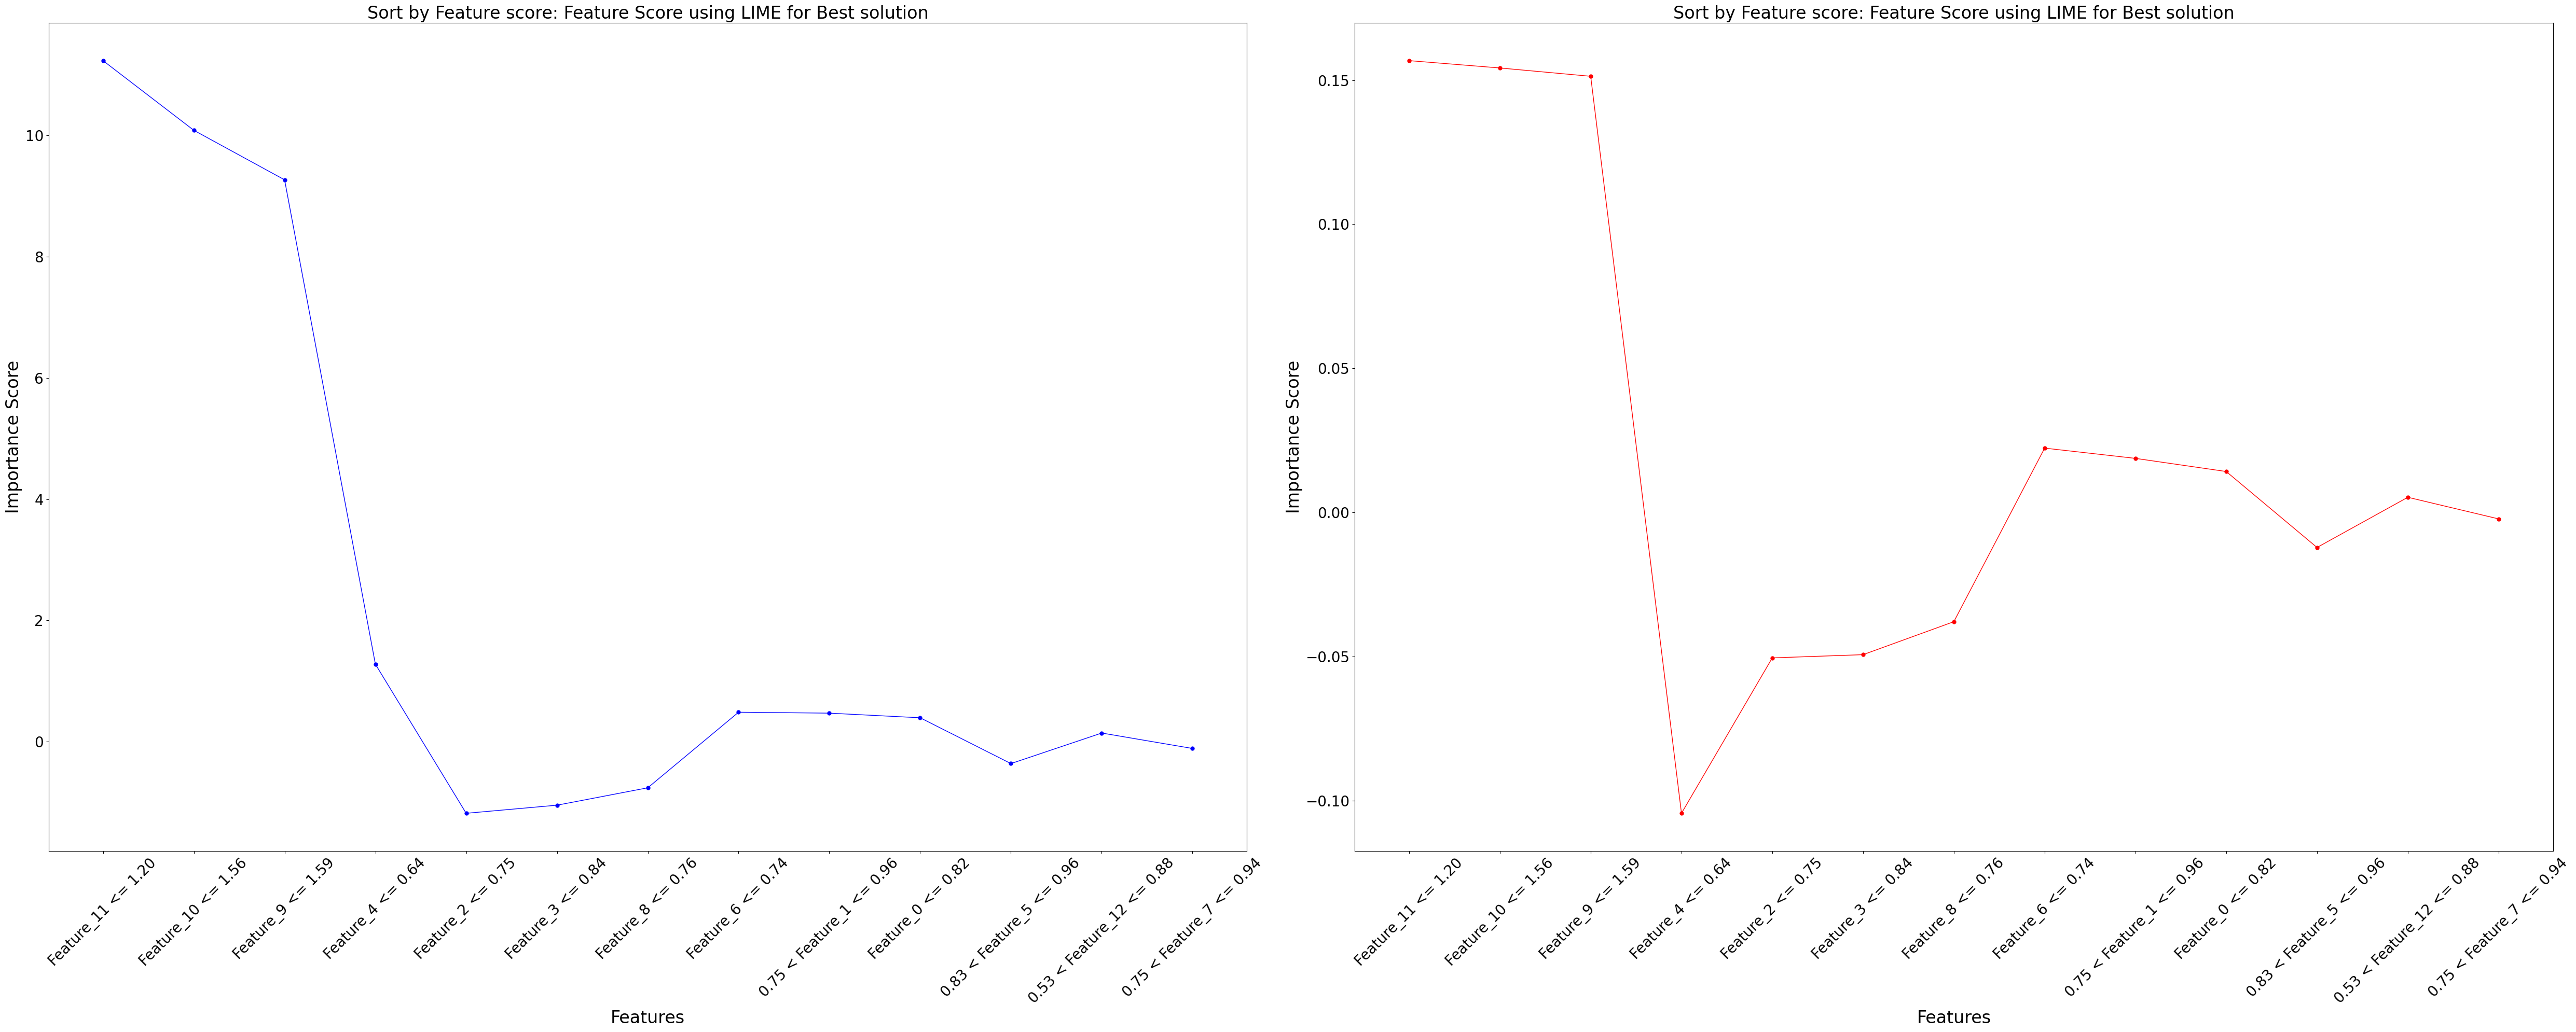

In [17]:
features = best_sol_score_reg.keys()
reg_score_values = best_sol_score_reg.values()  # Exclude first row and convert to float
class_score_values = best_sol_score_class.values()  # Exclude first row and convert to float
plotScores(features, reg_score_values, class_score_values, "Sort by Feature score: Feature Score using LIME for Best solution" )

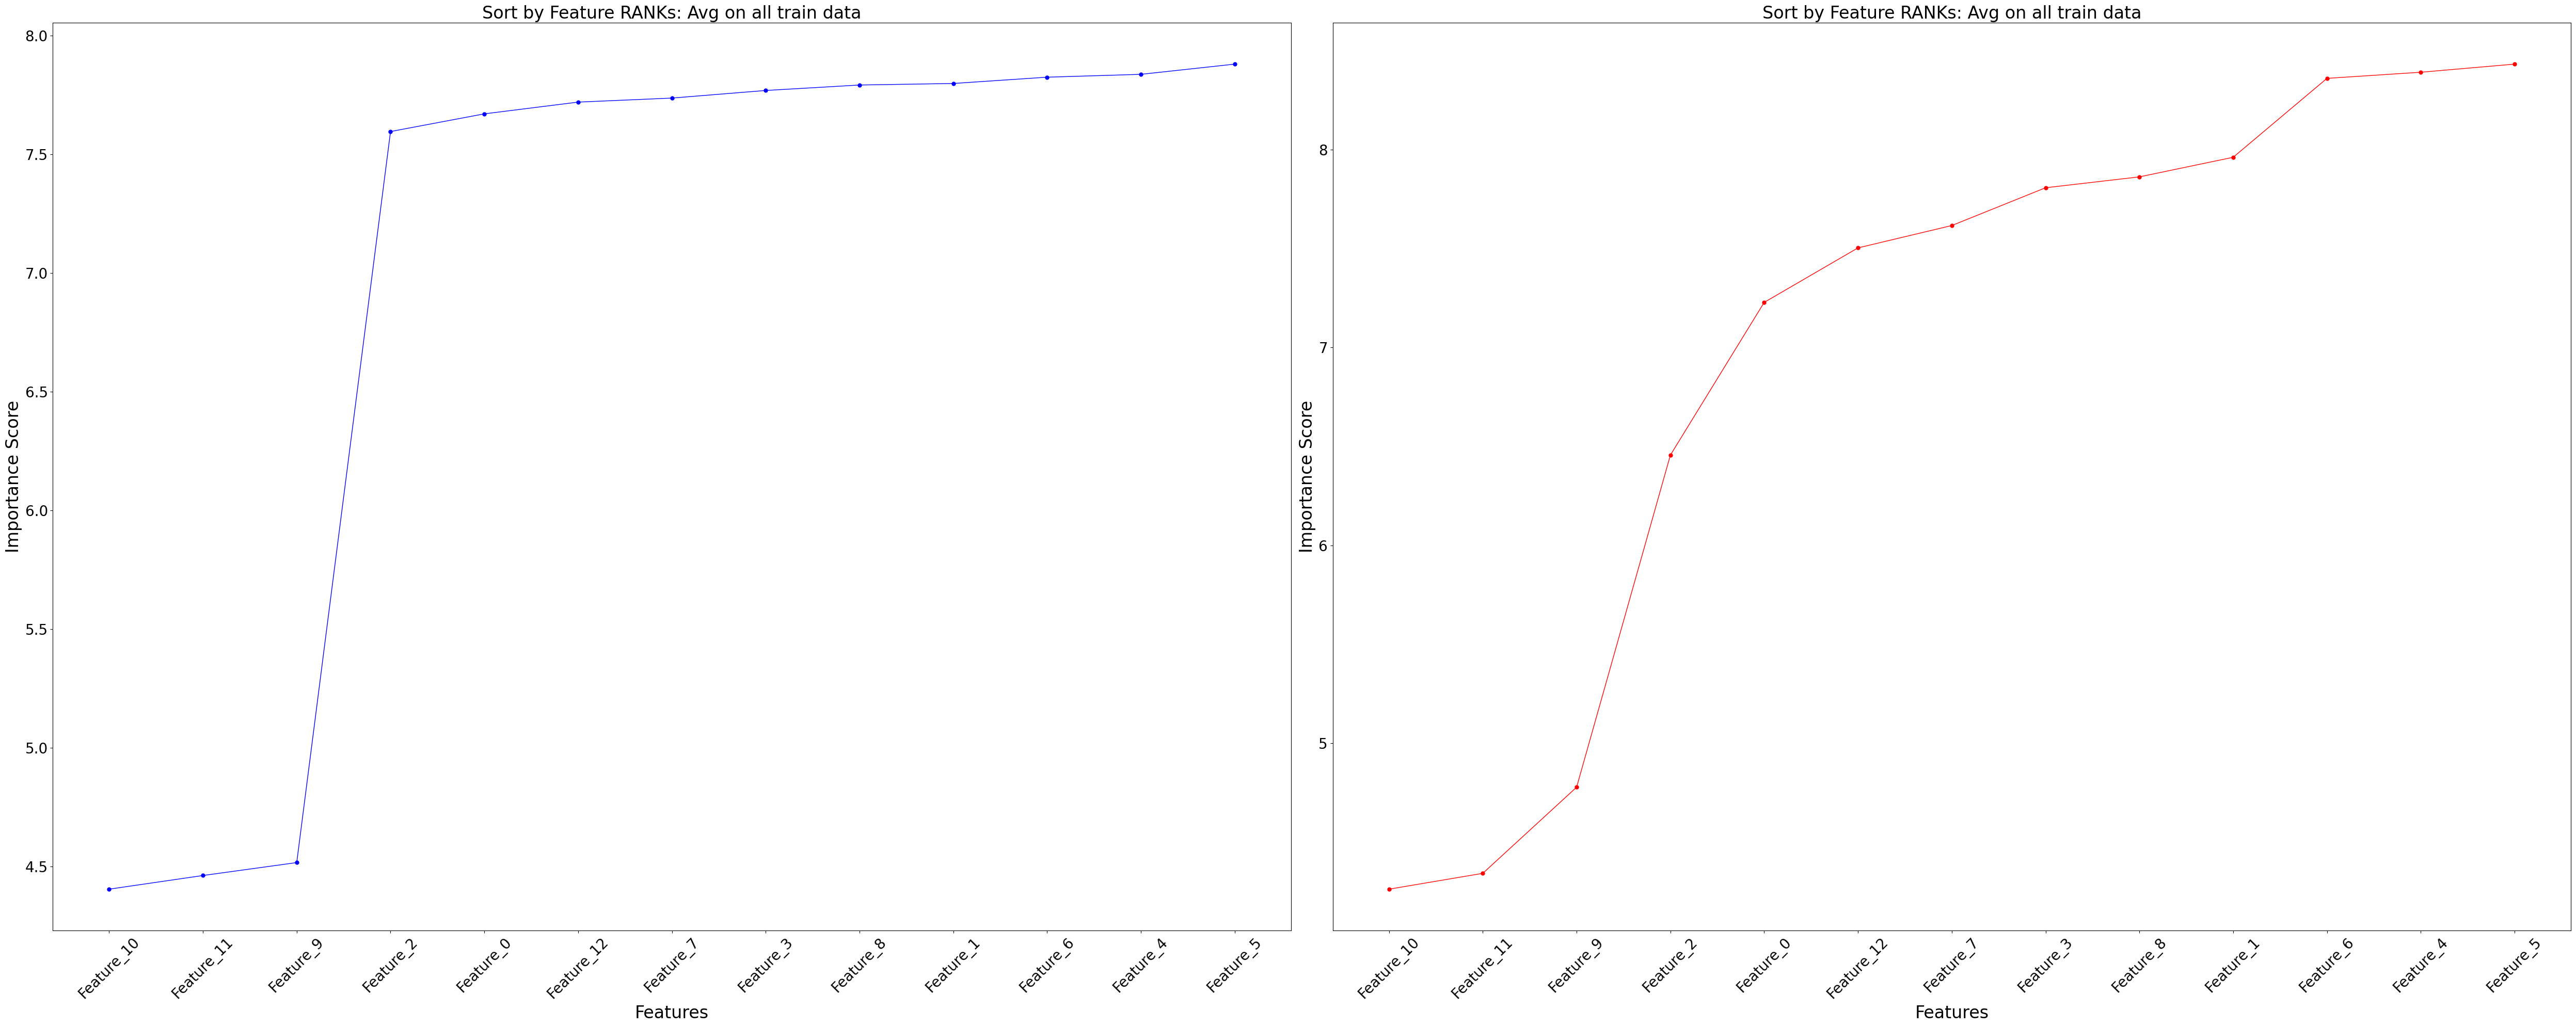

In [49]:
from scipy.stats import rankdata

def findRankByFeature(data):

    feature_names = data[0]
    scores = data[1:].astype(float)
    ranks = np.array([rankdata(-row, method='average') for row in scores])  # Negative for descending ranks
    avg_ranks = ranks.mean(axis=0)
    feature_avg_rank = dict(zip(feature_names, avg_ranks))
    sorted_feature_avg_rank = dict(sorted(feature_avg_rank.items(), key=lambda item: item[1]))
    return sorted_feature_avg_rank

reg_ranks = findRankByFeature(reg_lime_score)
class_ranks = findRankByFeature(class_lime_score)

plotScores(reg_ranks.keys(), reg_ranks.values(), class_ranks.values(), "Sort by Feature RANKs: Avg on all train data" )

In [50]:
def findTopKFeatures(reg_ranks, k):
    keys = [int( key.split("_")[-1]) for key in reg_ranks.keys()]
    return keys[: k ]
topKFeatures = findTopKFeatures( reg_ranks, 3)

def getFeatureNumberWithAdjustingParam(topKFeatures, reg_correlations):
    return {feature: reg_correlations[feature] for feature in topKFeatures}

print(getFeatureNumberWithAdjustingParam(topKFeatures, reg_correlations))

{10: -0.7984056706826558, 11: -0.8026639073625494, 9: -0.8400600506535494}


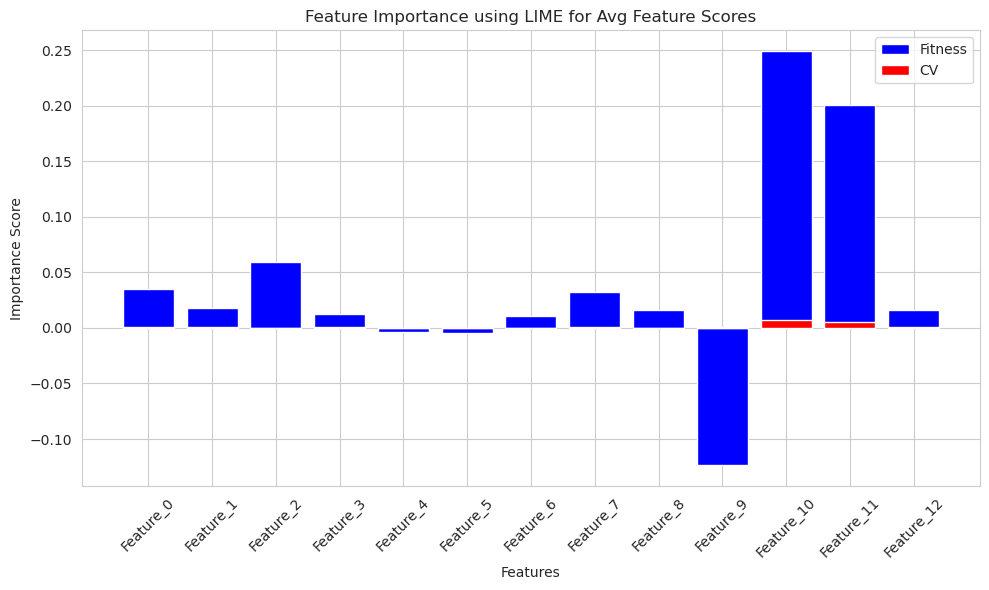

In [86]:
import matplotlib.pyplot as plt
import numpy as np

def plot_reg_class_score(reg_score_matrix, class_score_matrix, title, isBarChart=True):
    plt.figure(figsize=(10, 6))

    features = list(reg_score_matrix[0])

    reg_data_values = reg_score_matrix[1:].astype(float)  # Exclude first row and convert to float

    reg_score_averages = np.mean(reg_data_values, axis=0)
    
    if(isBarChart is False):
        plt.plot(features, reg_score_averages, marker='o', color='blue', linestyle='-', linewidth=1, markersize=5, label='Fitness')
    else:
        plt.bar(features, reg_score_averages, color='blue', label='Fitness')

    class_data_values = class_score_matrix[1:].astype(float)  # Exclude first row and convert to float
    class_score_averages = np.mean(class_data_values, axis=0)
    if(isBarChart is False):
        plt.plot(features, class_score_averages, marker='x', color='red', linestyle='-', linewidth=1, markersize=5, label='CV')
    else:
        plt.bar(features, class_score_averages, color='red', label='CV')

    
    plt.xlabel("Features")
    plt.ylabel("Importance Score")
    plt.title(f"Feature Importance using LIME for {title}")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot feature importance
plot_reg_class_score(reg_lime_score, class_lime_score, "Avg Feature Scores", True)


In [47]:
import shap
# Initialize SHAP Explainer
reg_explainer = shap.Explainer(regressor, X_train)
reg_shap_values = reg_explainer(X_test)

100%|===================| 1996/2000 [00:46<00:00]        

In [23]:
# tree_class_explainer = shap.TreeExplainer(classifier)
# tree_class_shap_values = tree_class_explainer(X_test)

In [50]:
# Sample K representative background samples
background_data = shap.sample(X_train, 100)  # For example, 100 samples

# Initialize KernelExplainer with the sampled background data
kernel_class_explainer = shap.KernelExplainer(classifier.predict_proba, background_data)

kernel_class_explainer = shap.KernelExplainer(classifier.predict_proba, background_data)
kernel_class_shap_values = kernel_class_explainer. shap_values(X_test)

100%|██████████| 2000/2000 [13:07<00:00,  2.54it/s]


In [51]:
shap.initjs()
shap.force_plot(kernel_class_explainer.expected_value[0], kernel_class_shap_values[..., 0], X_test)

(-88.03553850092344, 12.381932806669559, -1.0, 13.0)


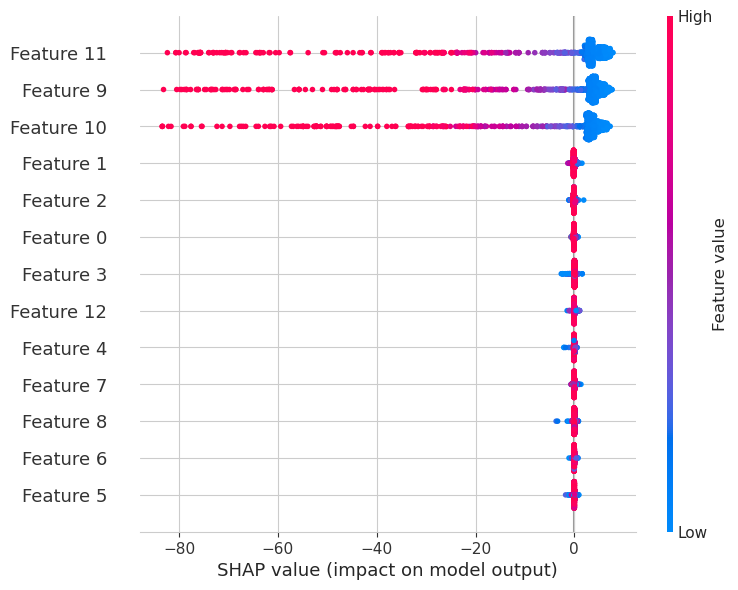

In [53]:

# Plot SHAP values summary for all test set (global explanation)
shap.plots.beeswarm(reg_shap_values, max_display = 13, show = False)
print(plt.axis())

plt.show()